<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/model_calibration_stkl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter estimation for hydraulic model calibration


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook implements sequential convex programming (SCP) to estimate pipe roughness coefficients for hydraulic model calibration. The following steps are performed to calibrate the hydraulic model:
1. Load network properties and operational data
2. Analyse preliminary model performance
3. Introduce sequential convex programming (SCP) algorithm to solve nonlinear parameter estimation problem

First, we clone the GitHub repository and install dependencies (only run this once).

In [3]:
# Run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

In [4]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [5]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [6]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'stkl.inp'
data_name = 'stkl_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. Make a function for this to call throughout the file.

In [7]:
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1000)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1000)

    # plot sensor vals
    if vals is not None:

        cmap = cm.get_cmap('RdYlGn_r')

        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

Plot network + sensor locations.

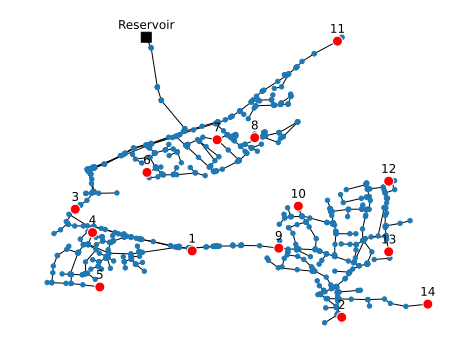

In [8]:
plot_network(wdn, sensor_idx)

### Preliminary model evaluation

Simulate initial (uncalibrated) hydraulic states over 8 days. We first define a function to compute network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

In [9]:
# define hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial `C_0` values.

In [10]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(os.path.join(net_dir, net_name), d_data, h0_data, C=C_0)

Compare simulated heads at sensor nodes (`sensor_idx`) with the simulated heads over the 8-day period. Visualise the results with, e.g., a boxplot of pressure residuals on the test dataset or a plot of the network with cumulative pressure residuals at sensor nodes.

Text(0, 0.5, 'Pressure residual [m]')

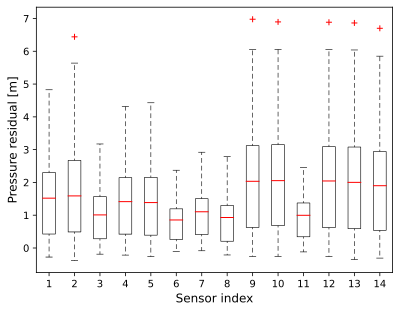

In [11]:
# compute pressure residuals
residuals_0 = h_0[sensor_idx,:] - h_data

# create figure and axis for box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

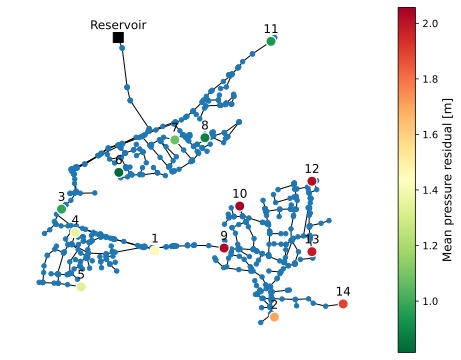

In [12]:
# spatial residuals plot
mean_residuals_0 = np.mean(residuals_0, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_0)

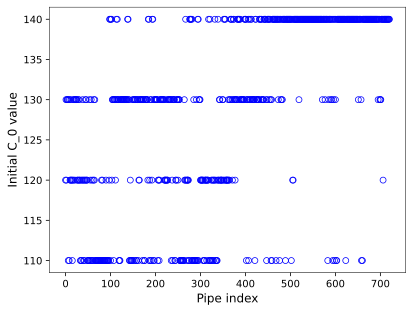

In [13]:
# C_0 value scatter plot (pipes only)
pipe_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('Initial C_0 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

### Parameter estimation problem

Based on the initial comparison between simulated and measured pressures, we propose to calibrate the hydraulic model as an inverse parameter estimation problem. The solution to this problem estimates pipe roughness (or H-W) coefficients. We assume valve losses are known and are therefore fixed at C=0.2.

We split the operational data (demand + pressure measurements) into train and test datasets.

In [14]:
# tain data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

The loss function is defined as the mean squared error (MSE) between simulated and measured pressures at sensor locations.

In [15]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for `C_0` values and training data.

In [16]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0, data_train['h_data'])
mse_0

3.446443112467536

Solve parameter estimation problem.

In [17]:
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation using `cvxpy` modelling interface.

In [18]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 1.7187453188125397 0.5012987991605129 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 0.12591647167164288 0.9267393078582248 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 0.12591647167164288 0.9267393078582248 6.050000000000001 

Iteration 3 successful! Update estimate and increase trust region size. 

3 0.08562328622088466 0.31999932110417034 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.07929119714932693 0.07395288537773093 7.320500000000002 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.07577864793195938 0.044299359117412125 8.052550000000002 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.07272295209343159 0.040323968847681926 8.857805000000003 

Iteration 7 successful! Update estimate and increa

In [19]:
C_1 = theta_k

# compute train mse
mse_train_1 = loss_fun(h_k, data_train['h_data'])
mse_train_1

0.05897494929708937

Evaluate results on test dataset.

In [20]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_1)

# compute test mse
mse_test_1 = loss_fun(h_test, data_test['h_data'])
mse_test_1

0.11992693656078128

Text(0, 0.5, 'Pressure residual [m]')

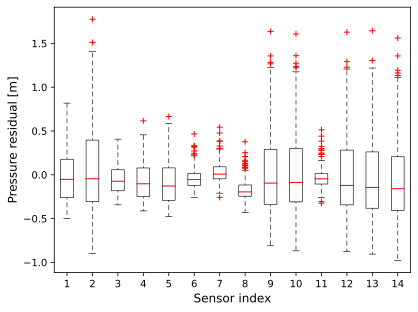

In [21]:
# compute pressure residuals
residuals_1 = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

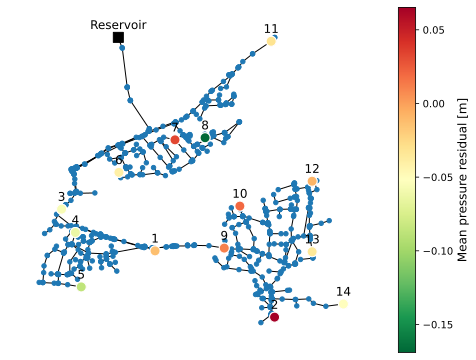

In [22]:
# spatial residuals plot
mean_residuals_1 = np.mean(residuals_1, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_1)

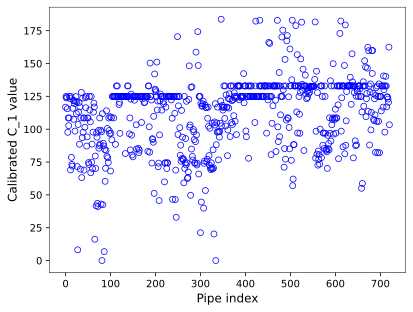

In [23]:
# C_1 value scatter plot (pipes only)
pipe_C = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('Calibrated C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)